# Eloquence score

Digging into the Rennes matrix of DSE x HPO. We've seen that not all EHRs are equal in the amount of information they provide. Some will have few HPO terms, while others may have many terms but little specificity. The aim of this report is to assess the proportion of information provided by the reports using several approaches, in order to develop a report eloquence/significance index. In a first approach, we looked at the number of HPO terms per report. But we can also take into account the specificity of the term in HPO tree.

In [2]:
import pandas as pd

In [3]:
ehr_mat = pd.read_csv("../data/ohe_20kRennes_EHR_2025_03_10.csv", index_col=0)

if "HP:0100021" in ehr_mat.columns: # petit check de sécu
    ehr_mat = ehr_mat.drop(columns=["HP:0100021"])
    print(ehr_mat.shape)

(19763, 4084)


# Quantité

La quantité est simplement le nombre de termes HPO apportés par le compte-rendu. 

In [ ]:
# ehr_mat['quantity'] = ehr_mat.sum(axis=1) # Calcul pour tous les compte-rendus

In [5]:
def convert_ehr_to_number_of_hpo(ehr:pd.DataFrame)-> pd.DataFrame:
    number_hpo_df = pd.DataFrame(index=ehr.index, columns=['nb_hpo'])
    number_hpo_df["nb_hpo"] = ehr.sum(axis=1)
    return number_hpo_df

In [6]:
metrics_df = convert_ehr_to_number_of_hpo(ehr_mat)

In [ ]:
print(metrics_df.head())

# Spécificité

Plus un terme HPO est spécifique et de manière générale plus il est bas dans l'arborescence. Nous considérons que notre arbre commence à anormalité phénotypique. Cette spécificité peut être améliorée en calculant par exemple dans quelle branche se trouve le terme. Voir si les branches sont très différentes en profondeur.


In [8]:
import helpers
from pprint import pprint

In [9]:
hpo_graph = helpers.load_ontology("../data/hpo_v2025_01_16.obo") # 
id_to_name, name_to_id = helpers.create_id_name_mappings(hpo_graph)

In [9]:
print(helpers.get_node_properties(hpo_graph, "HP:0000118"))

{'name': 'Phenotypic abnormality', 'def': '"A phenotypic abnormality." [https://orcid.org/0000-0002-0736-9199]', 'comment': 'This is the root of the phenotypic abnormality subontology of the HPO.', 'synonym': ['"Organ abnormality" EXACT []'], 'xref': ['UMLS:C4021819'], 'is_a': ['HP:0000001']}


Phenotypic abnormality = HP:0000118  
Doit extraire à partir de ce terme tout l'arbre.

In [ ]:
node = "HP:0000118"
for parent, child, key in hpo_graph.in_edges(node, keys=True):
    print(f"• {id_to_name[parent]} ⟵ {key} ⟵ {id_to_name[child]}")

In [10]:
pheno_subgraph = helpers.subset_ontology_by_term(hpo_graph, "HP:0000118")
print(pheno_subgraph)

MultiDiGraph named 'hp.obo' with 18387 nodes and 22741 edges


In [12]:
print(pheno_subgraph)
node = "HP:0000118"
for child, parent, key in pheno_subgraph.out_edges(node, keys=True):
    print(f"• {id_to_name[child]} ⟶ {key} ⟶ {id_to_name[parent]}")

MultiDiGraph named 'hp.obo' with 18387 nodes and 22741 edges


Aucun parent au terme anormalité phénotypique mais pourtant nous avons 15 986 sommets et 21 704 arêtes. Nous avons bien subdivisé l'arbre ontologique.

In [13]:
depth_dict = helpers.create_node_to_root_distance_dict(pheno_subgraph)
print(depth_dict)

{'HP:0000002': 2, 'HP:0000003': 7, 'HP:0000008': 5, 'HP:0000009': 5, 'HP:0000010': 4, 'HP:0000011': 6, 'HP:0000012': 6, 'HP:0000013': 8, 'HP:0000014': 4, 'HP:0000015': 6, 'HP:0000016': 6, 'HP:0000017': 6, 'HP:0000019': 6, 'HP:0000020': 4, 'HP:0000021': 7, 'HP:0000022': 5, 'HP:0000023': 5, 'HP:0000024': 5, 'HP:0000025': 5, 'HP:0000026': 4, 'HP:0000027': 7, 'HP:0000028': 7, 'HP:0000029': 7, 'HP:0000030': 6, 'HP:0000031': 5, 'HP:0000032': 5, 'HP:0000033': 6, 'HP:0000034': 7, 'HP:0000035': 6, 'HP:0000036': 6, 'HP:0000037': 6, 'HP:0000039': 6, 'HP:0000040': 7, 'HP:0000041': 7, 'HP:0000042': 5, 'HP:0000044': 4, 'HP:0000045': 6, 'HP:0000046': 7, 'HP:0000047': 6, 'HP:0000048': 7, 'HP:0000049': 7, 'HP:0000050': 6, 'HP:0000051': 7, 'HP:0000052': 6, 'HP:0000053': 8, 'HP:0000054': 8, 'HP:0000055': 5, 'HP:0000056': 6, 'HP:0000058': 6, 'HP:0000059': 8, 'HP:0000060': 7, 'HP:0000061': 6, 'HP:0000062': 5, 'HP:0000063': 8, 'HP:0000064': 8, 'HP:0000065': 7, 'HP:0000066': 7, 'HP:0000067': 6, 'HP:0000068':

In [14]:
import networkx as nx
def find_deepest_node(graph: nx.MultiDiGraph, root_id: str = "HP:0000118"):
    """
    Trouve le nœud le plus profond à partir d'un nœud racine donné.
    
    Parameters:
    - graph (nx.MultiDiGraph): Le graphe d'ontologie
    - root_id (str): L'identifiant du nœud racine (par défaut: "HP:0000118" pour phenotypic abnormality)
    
    Returns:
    - tuple: (nœud_le_plus_profond, profondeur_maximale, chemin_le_plus_long)
    """
    # Créer les mappages pour les noms
    id_to_name, name_to_id = helpers.create_id_name_mappings(graph)
    
    # Initialiser les distances et les chemins
    distances = {root_id: 0}
    paths = {root_id: [root_id]}
    
    # File pour le BFS
    queue = [root_id]
    
    # Nœud le plus profond et sa profondeur
    deepest_node = root_id
    max_depth = 0
    
    while queue:
        current = queue.pop(0)
        current_depth = distances[current]
        
        # Si ce nœud est plus profond que le précédent max, mettre à jour
        if current_depth > max_depth:
            max_depth = current_depth
            deepest_node = current
        
        # Trouver tous les enfants du nœud courant
        for child, parent, key in graph.in_edges(current, keys=True):
            if key == 'is_a' and child not in distances:
                # Distance au child est un de plus que la distance au parent
                distances[child] = current_depth + 1
                # Mémoriser le chemin
                paths[child] = paths[current] + [child]
                queue.append(child)
    
    # Convertir les IDs du chemin en noms pour plus de lisibilité
    path_names = [id_to_name.get(node_id, node_id) for node_id in paths[deepest_node]]
    
    return deepest_node, max_depth, path_names

def analyze_branch_depths(graph: nx.MultiDiGraph, root_id: str = "HP:0000118"):
    """
    Analyse les profondeurs de toutes les branches immédiates d'un nœud racine.
    
    Parameters:
    - graph (nx.MultiDiGraph): Le graphe d'ontologie
    - root_id (str): L'identifiant du nœud racine
    
    Returns:
    - dict: Dictionnaire mappant chaque enfant direct à sa profondeur maximale
    """
    id_to_name, name_to_id = helpers.create_id_name_mappings(graph)
    branch_depths = {}
    
    # Trouver tous les enfants directs
    direct_children = []
    for child, parent, key in graph.in_edges(root_id, keys=True):
        if key == 'is_a':
            direct_children.append(child)
    
    # Pour chaque enfant direct, trouver sa profondeur maximale
    for child in direct_children:
        deepest_node, depth, _ = find_deepest_node(graph, child)
        child_name = id_to_name.get(child, child)
        branch_depths[child_name] = {
            'max_depth': depth + 1,  # +1 car on compte à partir du nœud racine
            'deepest_node': id_to_name.get(deepest_node, deepest_node)
        }
    
    return branch_depths


In [15]:
find_deepest_node(pheno_subgraph, )

('HP:0011045',
 13,
 ['Phenotypic abnormality',
  'Abnormality of head or neck',
  'Abnormality of the head',
  'Abnormality of the face',
  'Abnormality of the mouth',
  'Abnormal oral morphology',
  'Abnormal oral cavity morphology',
  'Abnormality of the dentition',
  'Abnormality of the incisor',
  'Abnormal number of incisors',
  'Agenesis of incisor',
  'Agenesis of central incisor',
  'Agenesis of maxillary central incisor',
  'Agenesis of permanent maxillary central incisor'])

In [16]:
### Application de la profondeur moyenne sur les EHR
# Tableau -> 
import numpy as np
import pandas as pd

def convert_ehr_to_mean_depth_hpo(ehr:pd.DataFrame, hpo_depth_dict:dict)-> pd.DataFrame:
    """
    Convert an EHR matrix with binary HPO annotations to mean HPO depth values.
    
    Parameters:
    - ehr (pd.DataFrame): DataFrame with EHR records (rows) and HPO terms (columns)
                         containing binary values (0 or 1)
    - hpo_depth_dict (dict): Dictionary mapping each HPO ID to its depth in the ontology
    
    Returns:
    - pd.DataFrame: DataFrame with each EHR and its mean HPO depth
    """

    mean_depth_df = pd.DataFrame(index=ehr.index, columns=['mean_hpo_depth'])


    for ehr_id in ehr.index:
        present_hpo_terms= ehr.loc[ehr_id][ehr.loc[ehr_id]==1].index.tolist()

        if not present_hpo_terms:
            mean_depth_df.loc[ehr_id, 'mean_hpo_depth'] = np.nan
            continue

        hpo_depths = []

        for hpo_term in present_hpo_terms:
            # Check if the HPO term exists in our depth dictionary
            if hpo_term in hpo_depth_dict:
                hpo_depths.append(hpo_depth_dict[hpo_term])
            else:
                # If HPO term not found in depth dictionary, we could ignore it or handle differently
                print(f"Warning: HPO term {hpo_term} not found in depth dictionary")
                # Option to skip this term
                continue
        
        # Calculate the mean depth if we have any valid depths
        if hpo_depths:
            mean_depth_df.loc[ehr_id, 'mean_hpo_depth'] = sum(hpo_depths) / len(hpo_depths)
        else:
            mean_depth_df.loc[ehr_id, 'mean_hpo_depth'] = np.nan
    
    return mean_depth_df


In [17]:
ehr_depth = convert_ehr_to_mean_depth_hpo(ehr=ehr_mat, hpo_depth_dict=depth_dict)

In [41]:
print(ehr_depth)

            mean_hpo_depth
report1                3.0
report10               4.0
report100              4.0
report1000        5.666667
report10000            5.4
...                    ...
report9994             4.8
report9996             NaN
report9997        3.333333
report9998             6.0
report9999        5.545455

[19763 rows x 1 columns]


1. Nombre de branches racines couvertes (ou sous-arbres principaux)
2. Moyenne des distances shortest path entre les termes
3. Entropie (entropy-based diversity)

## Moyenne des distances shortest path entre les termes

In [18]:
undirected_graph = pheno_subgraph.to_undirected()

# Precompute all-pairs shortest path lengths (only between connected nodes)
all_shortest_paths = dict(nx.all_pairs_shortest_path_length(undirected_graph))

In [19]:
import pandas as pd
import numpy as np
from itertools import combinations

def weighted_mean_shortest_path_per_ehr(ehr_mat: pd.DataFrame, all_shortest_paths: dict) -> pd.DataFrame:
    weighted_mean_distances = []

    for patient_id, row in ehr_mat.iterrows():
        terms = row[row == 1].index.tolist()

        if len(terms) < 2:
            weighted_mean_distances.append(np.nan)
            continue

        distances = []
        for term1, term2 in combinations(terms, 2):
            if term2 in all_shortest_paths.get(term1, {}):
                distances.append(all_shortest_paths[term1][term2])

        # Calculate weighted mean
        num_comparisons = len(distances)
        if num_comparisons > 0:
            weighted_mean = np.sum(distances) / num_comparisons
        else:
            weighted_mean = np.nan

        weighted_mean_distances.append(weighted_mean)

    return pd.DataFrame({'weighted_mean_shortest_path': weighted_mean_distances}, index=ehr_mat.index)


In [20]:
diversity_df = weighted_mean_shortest_path_per_ehr(ehr_mat, all_shortest_paths)

In [21]:
for patient_id, row in ehr_mat.iterrows():
    terms = row[row == 1].index.tolist()
    for term1, term2 in combinations(terms, 2):
        print(term1, term2)
    break

In [40]:
print(metrics_df["nb_hpo"])

report1         1
report10        1
report100       1
report1000      9
report10000     5
               ..
report9994      5
report9996      0
report9997      3
report9998      1
report9999     11
Name: nb_hpo, Length: 19763, dtype: int64


In [22]:
diversity_df = weighted_mean_shortest_path_per_ehr(ehr_mat, all_shortest_paths)

In [35]:
print(diversity_df)

             weighted_mean_shortest_path
report1                              NaN
report10                             NaN
report100                            NaN
report1000                      7.777778
report10000                     8.000000
...                                  ...
report9994                      8.900000
report9996                           NaN
report9997                      6.333333
report9998                           NaN
report9999                      8.672727

[19763 rows x 1 columns]


## Entropie ou nombre de branches racines couvertes

## Information content 

Plus un terme est utilisé moins il doit avoir de poids car cela veut dire que c'est un terme générique utilisé très souvent.
Plus c'est un terme rare et plus il est utilisé de façon précise et spécifique donc plus il doit avoir de poids dans la balance.

In [23]:
term_counts = ehr_mat.sum(axis=0)
term_freq = term_counts / len(ehr_mat)

In [24]:
ic_scores = -np.log2(term_freq)
ic_scores.replace([np.inf, -np.inf], 0, inplace=True)

In [25]:
ehr_ic_matrix = ehr_mat * ic_scores

# Somme des IC pour chaque EHR
ehr_richness_scores = ehr_ic_matrix.sum(axis=1)

LE détail du calcul :
- compte par terme HPO son nombre d'utilisation
- calcul la fréquence pour chaqeu terme HPO dans le jeu de données
- IC(hpo) = -log2(fréquence du terme/nombre d'observations total)
- Fait une moyenne par EHR

In [9]:
print(ehr_mat.sum(axis=0))
print(len(ehr_mat))

HP:0000003    29
HP:0000010    98
HP:0000012     4
HP:0000013     8
HP:0000014     2
              ..
HP:6001132     1
HP:6001139     7
HP:6001146     1
HP:6001162     1
HP:6001163     1
Length: 4085, dtype: int64
19763


In [26]:
import numpy as np

def convert_ehr_to_mean_ic(ehr: pd.DataFrame) -> pd.DataFrame:
    term_counts = ehr.sum(axis=0)
    term_freq = term_counts / len(ehr)

    ic_scores = -np.log2(term_freq)
    ic_scores.replace([np.inf, -np.inf], 0, inplace=True)

    ehr_ic_matrix = ehr * ic_scores

    # Moyenne des IC pour chaque EHR (on divise la somme des IC par le nombre de termes annotés)
    ehr_richness_scores = pd.DataFrame(index=ehr.index)
    ehr_term_counts = ehr.sum(axis=1).replace(0, np.nan)  # éviter division par zéro
    ehr_richness_scores["ic_score"] = ehr_ic_matrix.sum(axis=1) / ehr_term_counts

    return ehr_richness_scores



ehr_richness  = convert_ehr_to_mean_ic(ehr_mat)

In [13]:
print(ehr_richness)

             ic_score
report1      4.234341
report10     1.502330
report100    1.502330
report1000   7.749199
report10000  6.887120
...               ...
report9994   6.648934
report9996        NaN
report9997   2.955151
report9998   7.032110
report9999   8.362248

[19763 rows x 1 columns]


In [27]:
num_high_ic_ehrs = (ehr_richness > 10).sum()

In [28]:
print(num_high_ic_ehrs/len(ehr_mat.columns)*100)

ic_score    20.127326
dtype: float64


## Fusion des différents jeux de données

In [29]:
from functools import reduce

dfs = [metrics_df, ehr_depth, diversity_df, ehr_richness] 
super_df = reduce(lambda left, right: left.join(right), dfs)

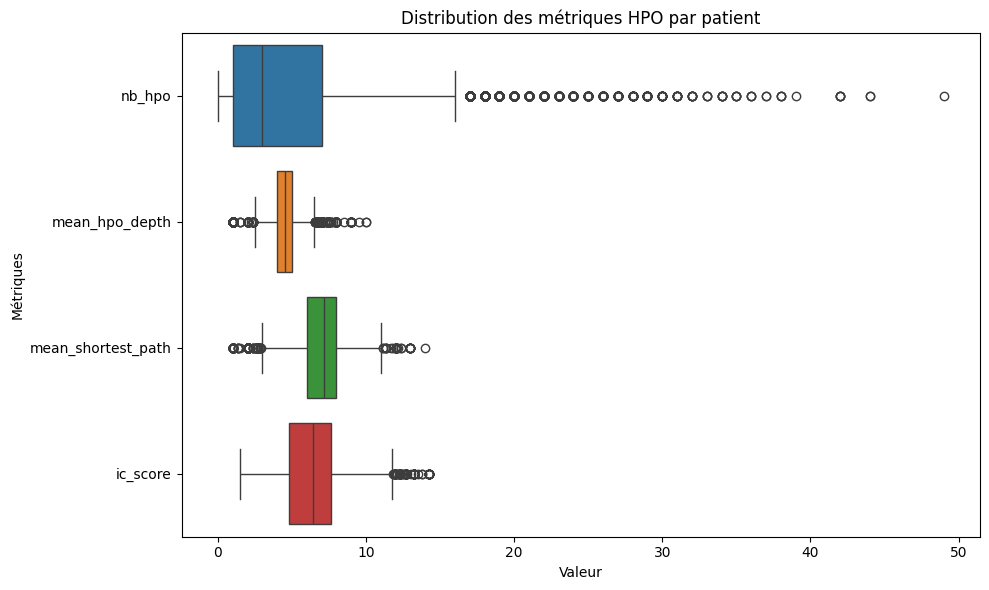

In [20]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
sns.boxplot(data=super_df, orient="h")  # horizontal pour mieux lire les échelles

# Personnalisation
plt.title("Distribution des métriques HPO par patient")
plt.xlabel("Valeur")
plt.ylabel("Métriques")
plt.tight_layout()

plt.show()

In [30]:
super_df.head()
super_df.to_csv("../output/eloquence_scores_dataframe.csv", sep=";")

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Melt comme avant
df_melted = super_df.melt(var_name="Metric", value_name="Value")

plt.figure(figsize=(12, 8))

sns.violinplot(
    data=df_melted,
    x="Value",
    y="Metric",
    hue="Metric",
    inner="box",   # équivalent du box=True
    linewidth=1
)

plt.title("Distribution of HPO Metrics per Patient (Violin Plot)", fontsize=18)
plt.xlabel("Values", fontsize=14)
plt.ylabel("Metrics", fontsize=14)
plt.legend(title="Metrics", fontsize=12)

plt.tight_layout()
plt.savefig("violin_plot.png", dpi=300)
# plt.show()
plt.close()


KeyboardInterrupt: 

In [19]:
super_df['mean_hpo_depth'] = pd.to_numeric(super_df['mean_hpo_depth'], errors='coerce')

In [20]:
super_df.describe()

,nb_hpo,mean_hpo_depth,weighted_mean_shortest_path,ic_score
count,19763.000000,15873.000000,12401.000000,15873.000000
mean,4.814957,4.508649,6.948804,6.139311
std,5.737548,1.014943,1.749699,2.305717
min,0.000000,1.000000,1.000000,1.502330
25%,1.000000,4.000000,6.000000,4.803142
50%,3.000000,4.500000,7.166667,6.439841
75%,7.000000,5.000000,8.000000,7.604295
max,49.000000,10.000000,14.000000,14.270514
